evaluate accuracy of U-Net with a ResNet-34 encoder on different city (Washington or Tel Aviv)

In [ ]:
!pip install segmentation_models
!pip install patchify

In [2]:
# Connecting to the Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
%matplotlib inline
from PIL import Image
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from osgeo import gdal

In [4]:
def image_file_to_array(city):  
  '''  read the satellite image file   '''
 
  image_file_path = os.path.join(dir, city, image_file_name)
  image = gdal.Open(image_file_path)
  image_array = image.ReadAsArray()
  image_array = np.transpose(image_array, [1, 2, 0])  # transpose the first and third axis

  return image_array


def park_file_to_array(city):

  '''  read the satellite image file   '''

  park_file_path = os.path.join(dir, city, park_file_name)
  park = gdal.Open(park_file_path)
  park_array = park.ReadAsArray()
  park_array = np.expand_dims(park_array, axis = 2) # expand from 2D to 3D
  park_array[park_array > 1] = 1                    # repalce values greater than 1 with 1

  return park_array

In [5]:
dir =  #location of main folder
image_file_name = 'image_bgr_nir_ndvi_landcover_ndbi_ndwi.tif'
park_file_name = 'parks.tif'

city =  "Washington" #"Tel_Aviv"

image_array = image_file_to_array(city)
park_array = park_file_to_array(city)

In [6]:
print(image_array.shape)
print(park_array.shape)

(2082, 1811, 8)
(2082, 1811, 1)


In [9]:
#chip3 [2,3,4]
image_array = image_array[:,:,[2,3,4]]

In [8]:
# define functions to crop images and corresponding masks into proper size

def create_image_chips(image_file, patch_size, step):
  '''
  This function creates chips for satellite image
  Input  - image_file: np.array of satellite image
         - patch_size: size of output chips, e.g. 256 or 128
         - step: stride for cropping (when smaller then stride you get overlapping chips)
  Output - np.array for chips of satellite image
  '''
 
  scaler = MinMaxScaler() # scale to the min = 0, and max = 1
  
  image_dataset = []
  patches_img = patchify(image_file, (patch_size, patch_size, image_file.shape[2]), step=step)  
  
  for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
      single_patch_img = patches_img[i,j,:,:]   
      # scale to min = 0, max = 1          
      single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
      single_patch_img = single_patch_img[0] # Drop the extra unecessary dimension that patchify adds.                               
      image_dataset.append(single_patch_img) 
  image_dataset = np.array(image_dataset)

  return image_dataset

def create_mask_chips(park_file, patch_size, step):
  '''
  This function creates chips for park images (rasterized park dataset)
  Input  - park_file: np.array of satellite image
         - patch_size: size of output chips, e.g. 256 or 128
         - step: stride for cropping (when smaller then stride you get overlapping chips) ! patch and stride should be the same for mask and for images
  Output - np.array for chips of mask
  '''
  scaler = MinMaxScaler() # scale to the min = 0, and max = 1
  park_dataset = []
  patches_img = patchify(park_file, (patch_size, patch_size, 1), step=step)  
  
  for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):      
      single_patch_img = patches_img[i,j,:,:]
      # scale to min = 0, max = 1 
      single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
      single_patch_img = single_patch_img[0] # Drop the extra unecessary dimension that patchify adds.                               
      park_dataset.append(single_patch_img)
  park_dataset = np.array(park_dataset)

  return park_dataset

In [11]:
#create patches
patch_size=256
step=patch_size
image_dataset = create_image_chips(image_array, patch_size=patch_size, step=step)
park_dataset = create_mask_chips(park_array, patch_size=patch_size, step=step)

print(image_dataset.shape)
print(park_dataset.shape)

(56, 256, 256, 3)
(56, 256, 256, 1)


In [13]:
import tensorflow as tf
from keras.models import load_model
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.optimizers import Adam
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [21]:
model_test = load_model('location to save the model', compile = False)

model_test.compile(optimizer=Adam(learning_rate = 1e-4), loss = sm.losses.binary_focal_dice_loss, 
              metrics=[sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy']) # use the same parameters as in original training!

In [22]:
# precessing X to fit the model
from tensorflow.keras.utils import to_categorical

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
X_test = preprocess_input(image_dataset)

# turn y to categorical data
test_masks_cat = to_categorical(park_dataset, num_classes=2)
y_test_cat = test_masks_cat.reshape((park_dataset.shape[0], 
                                     park_dataset.shape[1], 
                                     park_dataset.shape[2], 2))
print(X_test.shape, y_test_cat.shape)

(56, 256, 256, 3) (56, 256, 256, 2)


In [23]:
# predict and metrics
loss, IoU, F1score, precision, recall, acc  = model_test.evaluate(X_test, y_test_cat, verbose = 1)

print("Loss is ", loss)
print("IoU is ", IoU)
print("F1 score is ", F1score)
print("Precision is ", precision)
print("Recall is ", recall)
print("Accuracy is ", acc)

2/2 [==============================] - 11s 4s/step - loss: 0.4121 - iou_score: 0.6212 - f1-score: 0.7327 - precision_2: 0.8859 - recall_2: 0.8899 - accuracy: 0.8879
Loss is  0.41210129857063293
IoU is  0.6211862564086914
F1 score is  0.7326948642730713
Precision is  0.8859013915061951
Recall is  0.8898939490318298
Accuracy is  0.8879173994064331


In [25]:
import random
import matplotlib.pyplot as plt

(1, 256, 256, 3)


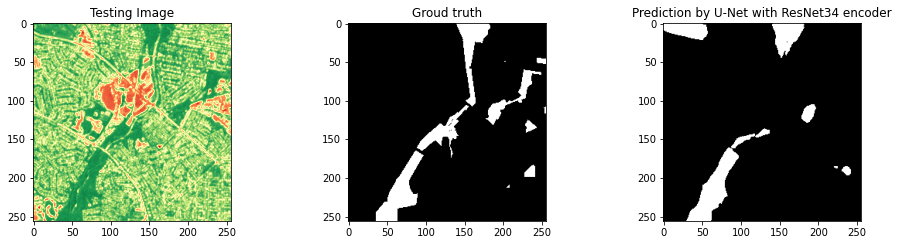

In [35]:
test_img_number = random.randint(0, len(image_dataset)-1)
test_img = X_test[test_img_number]
ground_truth = park_dataset[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
print(test_img_input.shape)

test_img_input1 = preprocess_input(test_img_input)

test_pred = model_test.predict(test_img_input)
test_prediction = np.argmax(test_pred, axis=3)[0,:,:]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,2], cmap='RdYlGn')

plt.subplot(232)
plt.title('Groud truth')
plt.imshow(ground_truth[:,:,0], cmap='gray')

plt.subplot(233)
plt.title('Prediction by U-Net with ResNet34 encoder')
plt.imshow(test_prediction, cmap='gray')

plt.show()